### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Reacher Unity environment.

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='unity_envs/Crawler_Linux_NoVis/Crawler.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Lets print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

### 3. Take Random Actions in the Environment

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents) # initialize the score (for each agent)
step=0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    step+=1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.4039602749592935


### 4. Training the agent!

Now it's turn to train an agent to solve the environment!  When training the environment, we have to set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import random
import datetime
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

# imports for rendering outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# defining the ddpg agent
agent = Agent(state_size=env_info.vector_observations.shape[1], 
               action_size=brain.vector_action_space_size,
               num_agents=num_agents, random_seed=0)

Lets target a score of 30 for solving this environment
`target_score=30`

In [9]:
def ddpg(n_episodes=500,max_t=1000,target_score=30,PRINT_EVERY=50):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            #print (states[0], actions, rewards[0], next_states[0], dones[0])
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break
        avg_agent_score = np.mean(score)
        scores_deque.append(avg_agent_score)
        scores.append(avg_agent_score)
        if max_score<avg_agent_score:
            max_score=avg_agent_score
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque),avg_agent_score), end="")
        if i_episode % PRINT_EVERY == 0:
            torch.save(agent.actor_local.state_dict(), 'trained_models/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'trained_models/checkpoint_critic.pth')
            print('\rEpisode {} ... Average reward: {:.2f} ... Max reward: {:.2f}'.format(i_episode,
                                                                            np.mean(scores_deque),max_score))
#         if np.mean(scores_deque)>target_score:
#             torch.save(agent.actor_local.state_dict(), 'trained_models/checkpoint_actor.pth')
#             torch.save(agent.critic_local.state_dict(), 'trained_models/checkpoint_critic.pth')
            
#             print ("\nEnvironment solved in {} episodes! ... Avg Reward: {}".format(i_episode-100,np.mean(scores_deque)))
#             break
            
    return scores

In [10]:
scores = ddpg()

Episode 50 ... Average reward: 0.51 ... Max reward: 1.44
Episode 100 ... Average reward: 0.58 ... Max reward: 3.01
Episode 150 ... Average reward: 0.45 ... Max reward: 3.01
Episode 200 ... Average reward: 0.29 ... Max reward: 3.01
Episode 250 ... Average reward: 0.36 ... Max reward: 3.01
Episode 300 ... Average reward: 0.37 ... Max reward: 3.01
Episode 350 ... Average reward: 0.34 ... Max reward: 3.01
Episode 400 ... Average reward: 0.30 ... Max reward: 3.01
Episode 450 ... Average reward: 0.33 ... Max reward: 3.01
Episode 500 ... Average reward: 0.33 ... Max reward: 3.01


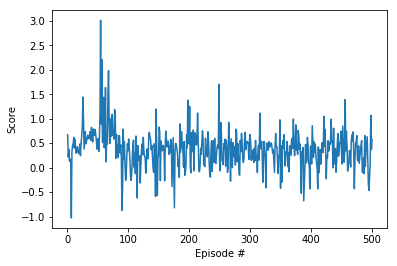

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()